# 21M.387 Fundamentals of Music Processing

## Fourier Transform, part 2

Further exploration of the DFT: The matrix / linear-algebra view, the FFT, spectral resolution, and non-stationary signals using the Short-Time Fourier Transform

In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (10, 4)
fmp.documentation_button()

## Reading

Chapter 2.1.4 (pp 53 – 57), 2.5 (93 – 105)

<img src="images/book_cover.png" width=200>

## The DFT
$$X[k] = \sum_{n=0}^{N-1}x[n]e^{-j 2 \pi kn / N } \text{, for } k \in [0:N-1]$$

We defined a sinusoid as:  
$$x[n] = A \cos(2 \pi {k \over N} n + \phi)$$
where $f$, the frequency of the sinusoid in Hertz is: 
$$f = k {F_s \over N}$$

Back to the first synthetic example.  
We create funky-shaped $x[n]$, by adding the following sinusoids:
- $\{A=1.0, k=1, \phi=0 \}$
- $\{A=0.6, k=3, \phi=2.1 \}$
- $\{A=0.4, k=8, \phi=0.6 \}$

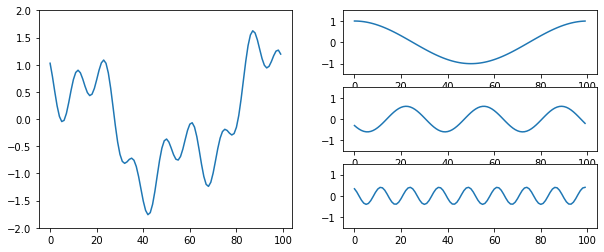

In [2]:
# back to our first example:

# helper functions:
def make_cosine(a, k, ph, N) :
    n = np.arange(N)
    return a * np.cos( 2 * np.pi * k / N * n + ph)

N = 100
c1 = make_cosine(1.0, 1, 0, N)
c2 = make_cosine(0.6, 3, 2.1, N)
c3 = make_cosine(0.4, 8, 0.6, N)
x = c1 + c2 + c3

plt.figure()
plt.subplot(1,2,1)
plt.plot(x)
plt.ylim(-2, 2)

for i, c in enumerate((c1, c2, c3)):
  plt.subplot(3, 2, 2*i+2)
  plt.plot(c)
  plt.ylim(-1.5, 1.5)

## DFT in code

To calculate the DFT, think of it as a series of $N$ dot products, each one calculating the value for a different $k$.

The entire expression can be expressed as a single Matrix Multiply.

<font color='red'>__Whiteboard__</font>: Matrix Multiplication and the DFT matrix

In [3]:
# [livecode]
# NOTE: in class he renamed "w" aka omega to "tpon" ("two pi over N")

def make_dft_mtx_during_class(N):
    P = np.zeros((N,N), complex)
    w = -2j * np.pi / N
    n = np.arange(N)
    for k in range(N):
        P[k,:] = np.exp(w * n * k)
    return P

def make_dft_mtx(N):
    # create "probes" matrix:
    P = np.zeros((N,N), dtype=complex)
    j2pn = -2j * np.pi / N * np.arange(N)
    for k in range(N):
        P[k,:] = np.exp(j2pn * k)

    return P

# another way of creating the same DFT matrix:
def make_dft_mtx_v2(N):
    n = np.arange(N)
    kn = np.outer(n, n)  # creates a matrix with the exponents for w
    w = -2j * np.pi / N
    return np.exp( w * kn)

def dft(x):
    N = len(x)
    fb = make_dft_mtx(N)
    
    return np.dot(fb, x)

with np.printoptions(2, suppress=True):
    print(make_dft_mtx_v2(8).real)
    print(make_dft_mtx_v2(8).imag)    
# [livecode]

[[ 1.    1.    1.    1.    1.    1.    1.    1.  ]
 [ 1.    0.71  0.   -0.71 -1.   -0.71 -0.    0.71]
 [ 1.    0.   -1.   -0.    1.    0.   -1.   -0.  ]
 [ 1.   -0.71 -0.    0.71 -1.    0.71  0.   -0.71]
 [ 1.   -1.    1.   -1.    1.   -1.    1.   -1.  ]
 [ 1.   -0.71  0.    0.71 -1.    0.71 -0.   -0.71]
 [ 1.   -0.   -1.    0.    1.   -0.   -1.   -0.  ]
 [ 1.    0.71 -0.   -0.71 -1.   -0.71 -0.    0.71]]
[[ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.71 -1.   -0.71 -0.    0.71  1.    0.71]
 [ 0.   -1.   -0.    1.    0.   -1.   -0.    1.  ]
 [ 0.   -0.71  1.   -0.71 -0.    0.71 -1.    0.71]
 [ 0.   -0.    0.   -0.    0.   -0.    0.   -0.  ]
 [ 0.    0.71 -1.    0.71 -0.   -0.71  1.   -0.71]
 [ 0.    1.   -0.   -1.    0.    1.   -0.   -1.  ]
 [ 0.    0.71  1.    0.71 -0.   -0.71 -1.   -0.71]]


The DFT of $x[n]$ is plotted below, using our own `dft` function and `np.fft.fft`

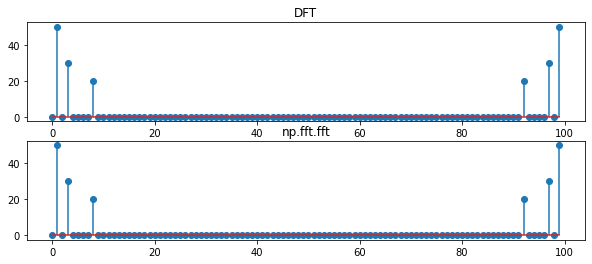

In [4]:
ft1 = dft(x)
ft2 = np.fft.fft(x)

plt.subplot(2,1,1)
plt.stem(np.abs(ft1))
plt.title('DFT')

plt.subplot(2,1,2)
plt.stem(np.abs(ft2));
plt.title('np.fft.fft');

It works!

Let's look at the DFT Matrix graphically.

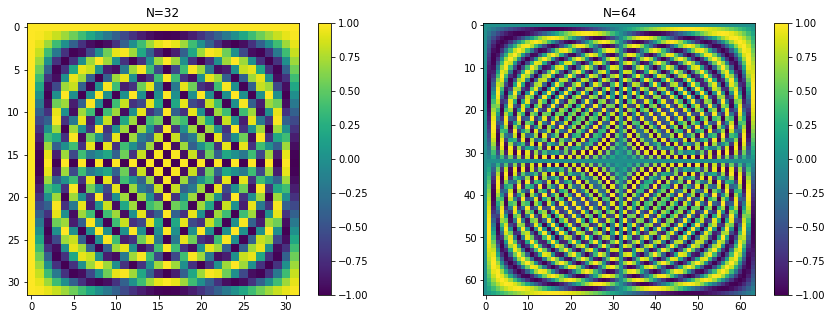

In [5]:
dft_mtx32 = make_dft_mtx(32)
dft_mtx64 = make_dft_mtx(64)

# real part: even symmetry
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(np.real(dft_mtx32))
plt.title('N=32')
plt.colorbar()

# imaginary part: odd symmetry
plt.subplot(1,2,2)
plt.imshow(np.imag(dft_mtx64))
plt.title('N=64')
plt.colorbar()
plt.show()

# NOTE: the real part is even symmetric, and the imaginary part is odd symmetric

Pretty! And Symmetric.

Which leads to the DFT itself being symmetric:

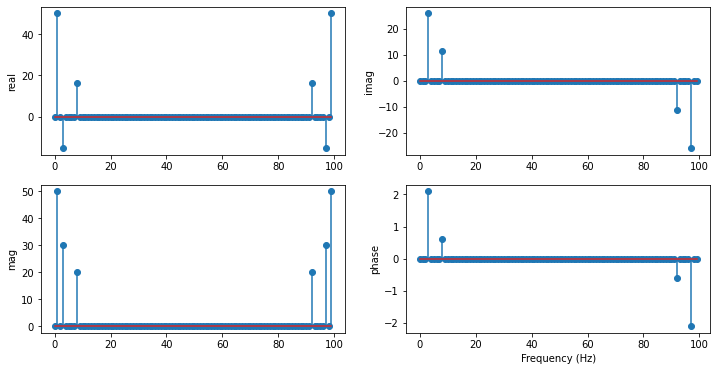

In [6]:
ft = np.fft.fft(x)

ft_mag = np.abs(ft)
ft_ph  = np.angle(ft)
ft_ph[ft_mag < 0.0001] = 0

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.stem(ft.real)
plt.ylabel('real')
plt.subplot(2,2,2)
plt.stem(ft.imag)
plt.ylabel('imag')
plt.subplot(2,2,3)
plt.stem(ft_mag)
plt.ylabel('mag')
plt.subplot(2,2,4)
plt.stem(ft_ph)
plt.ylabel('phase')

plt.xlabel('Frequency (Hz)');

Note that the DFT is symmetric. If $x[n]$ is a _real_ signal (which is always the case for us), the 2nd half of the DFT is redundant, and is therefore often dropped.

The useful information for the DFT therefore resides in the range $k \in [0, N/2 + 1]$

## The Fast Fourier Transform

Computing the DFT for $x[n]$ of length $N$ using the above equations is an $O(N^2)$ operation.  
Because of certain symmetry properties in the calulcations, an optimzed version of the DFT can be achieved in $O(N \log N)$ if $N$ is a power of 2.

This difference in computation time is significant. For example:
- DFT with $N = 1024$ needs ~1M mult-and-add operations
- FFT with $N = 1024$ needs ~10k mult-and-add operations. That's 100 times faster!

To handle non-power-of-2 $N$, you can:
- zero-pad $x[n]$ to the next power of two.
- use `np.fft.fft` anyway. There are fast DFT algorithms for non-power-of-two as well.

Also note that since $x[n]$ is _real_ you can use `np.fft.rfft` which computes only $N/2+1$ points (and is twice as fast).

In [7]:
# here are some timed examples:
x = np.random.random(1024)

print('\nRegular DFT')
%timeit dft(x)


Regular DFT
38.5 ms ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
print('\nRegular FFT')
%timeit -n 1000 np.fft.fft(x)


Regular FFT
21.7 µs ± 2.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
print('\nReal FFT')
%timeit -n 1000 np.fft.rfft(x)


Real FFT
14.8 µs ± 2.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
print('\nNon power-of-two FFT')
x = np.random.random(1030)
%timeit -n 1000 np.fft.rfft(x)


Non power-of-two FFT
45.2 µs ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Spectral Leakage

What about this:

In [11]:
def magft(x):
    return np.abs(np.fft.rfft(x))

@interact(k=fmp.slider(4.0, 6.0, 5.5))
def cos_and_dft(k):
    N = 128
    x = make_cosine(1.0, k, 0, N)
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(x)
    plt.ylim(-1.5, 1.5)
    plt.title('$x(n)$')
    plt.subplot(1,2,2)
    plt.stem(magft(x))
    plt.ylim(0,65)
    plt.title('$|X(k)|$')
    plt.show()

interactive(children=(FloatSlider(value=5.5, continuous_update=False, description='k', max=6.0, min=4.0), Outp…

The "problem" is that the frequency $k = 5.5$ is not an integer and is thus not "perfectly capturable" by a DFT, since all values of $k$ are integers.

You can explain this in a few ways

The DFT behaves as if signal $x[n]$ is actually _periodically extended_ in both directions to form in an infinite signal. Doing this on a non-integer $k$ results in a "glitch":

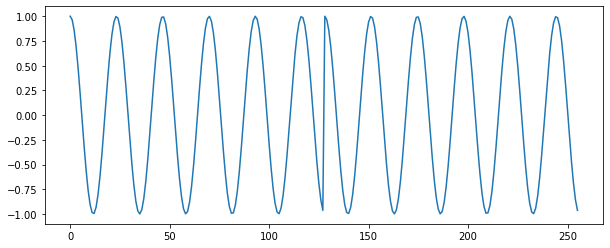

In [12]:
# periodically extend x:
N = 128
x = make_cosine(1.0, 5.5, 0, N)
y = np.tile(x, 2)

plt.figure()
plt.plot(y);

You can think of this glitch as a high-frequency spike that introduces lots of other frequencies or "sidebands"

Or: the DFT must "hack together" a bunch of integer frequency sinusoids with different weights and phases to create the non-integer frequency.

In [13]:
# pull out Amp, K, and phase from FFT:
x_ft = np.fft.rfft(x)
x_amp = np.abs(x_ft) * 2 / N
x_phase = np.angle(x_ft)
cos_params = list(zip(x_amp, np.arange(len(x_amp)), x_phase))

# but now, sort them in order of amplitude (the "most important" ones first)
cos_params.sort(key = lambda x : x[0], reverse=True)

@interact(num_sines=fmp.slider(0, len(cos_params) - 1, 0))
def reconstruct(num_sines=0):
    x = np.zeros(N)
    y = np.zeros(N)
    params_txt = ''
    for p in cos_params[:num_sines]:
        y = make_cosine(p[0], p[1], p[2], N)
        params_txt = 'A=%.2f k=%d, phi=%.2f' % p
        x += y
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    plt.plot(y, 'r')
    plt.ylim(-1.5, 1.5);
    plt.text(10, 1, params_txt, fontsize=20)
    plt.subplot(2,1,2)
    plt.plot(x)
    plt.ylim(-1.5, 1.5)
    plt.title("sum of top %d sinusoids" % num_sines)
    plt.show();

interactive(children=(IntSlider(value=0, continuous_update=False, description='num_sines', max=64), Output()),…

## Zero-padding

Zero padding the signal $x[n]$ will cause finer frequency interpolation.

Joana: this is a trick to help you recover the original frequency when it's not an integer, such as "5.5". The reason why it works is because you get a much finer resolution when you zero-pad.

Joana: CAVEAT: it doesn't let you identify *multiple* frequencies if they're interfering with each other. In example 3 cells down you see this. Solution: need to include more signal to be able to do that.

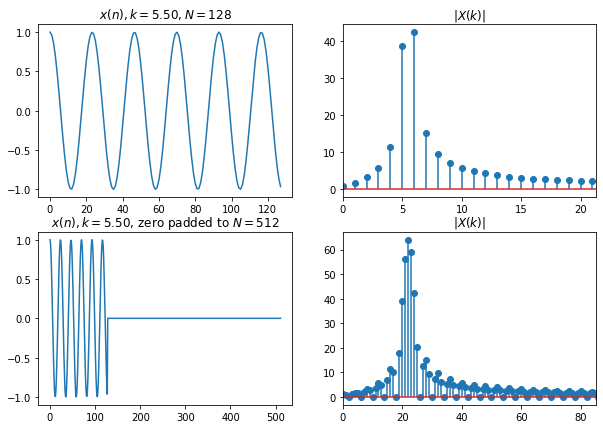

In [14]:
N = 128
k = 5.5
x = make_cosine(1.0, k, 0, N)

N1 = 128 * 4
zp_len = N1 - len(x)
x1 = np.concatenate((x, np.zeros(zp_len)))

plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.plot(x)
plt.title(f'$x(n), k={k:.2f}, N=128$')
plt.subplot(2,2,2)
plt.stem(magft(x))
plt.xlim(0, len(x)/6.)
plt.title('$|X(k)|$')
plt.subplot(2,2,3)

plt.plot(x1)
plt.title(f'$x(n), k={k:.2f}$, zero padded to $N={N1}$')
plt.subplot(2,2,4)
plt.stem(magft(x1))
plt.xlim(0, len(x1)/6.)
plt.title('$|X(k)|$')
plt.show()

Find the location of peak of $X[k]$

In [15]:
# [livecode]
peak = np.argmax(magft(x))
print(peak, len(x))
peak1 = np.argmax(magft(x1))
print(peak1, len(x1))

# so, a more accurate freq estimation is:
peak1 * len(x) / len(x1)

6 128
22 512


5.5

Another example:
$$ x[n] = \cos(2 \pi {k_1 \over N} n) + \cos(2 \pi {k_2 \over N} n) $$
with:
- $ k_1 = 49.1$
- $ k_2 = 53.2$

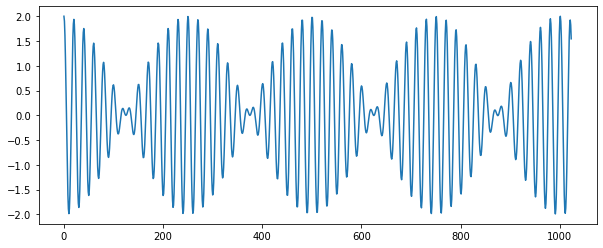

In [16]:
c1 = make_cosine(1, 49.1, 0, 1024)
c2 = make_cosine(1, 53.2, 0, 1024)
x = c1 + c2
plt.plot(x)
plt.show()

See how the DFT resolution changes as we modify the _amount_ of signal and the _amount_ of zero-padding.

In [17]:
@interact(zpf=(1,8), ni=(0,3))
def zp_test(zpf=1, ni=0):
    sig_len = (128,256,512,1024)[ni]
    N = sig_len * zpf
    xw = np.concatenate((x[:sig_len], np.zeros(N-sig_len)))
    mft = np.abs(np.fft.rfft(xw))
    peaks = fmp.find_peaks(mft, .5)
    
    plt.figure(figsize=(10, 7))
    plt.subplot(2,1,1)
    plt.plot(xw)
    txt = '$N=%d$    $L_{sig} = %d$    $L_{zp} = %d$' % (N, sig_len, N - sig_len)
    plt.title(txt)
    plt.subplot(2,1,2)
    plt.title('$|X(k)|$')
    plt.plot(mft[0:int(N/8)])
    plt.show()

interactive(children=(IntSlider(value=1, description='zpf', max=8, min=1), IntSlider(value=0, description='ni'…

<font color='red'>__Whiteboard__</font>: Frequency resolution and discrimination

### Non-Stationary Signals

The DFT says nothing about _when_ frequencies occur. For long stretches of audio that changes over time, we need a better tool.

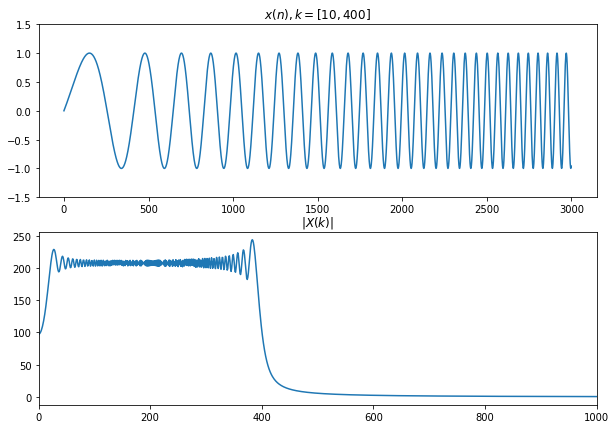

In [18]:
# smoothly increasing sinusoid that starts with low and ends with high frequency
def make_chirp(k_start, k_end, N) :
    n = np.arange(N)
    dk = (k_end - k_start) / float(N)
    return np.sin(2*np.pi * (k_start + dk/2 * n) * n / N)

N = 8192
x = make_chirp(10, 400, N)
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(x[0:3000])
plt.ylim(-1.5, 1.5)
plt.title('$x(n), k=[10,400]$ ')
plt.subplot(2,1,2)
plt.plot(magft(x))
plt.xlim(0,1000);
plt.title('$|X(k)|$')

ipd.Audio(x, rate = N)

### Sliding Window

To pick a window of a signal, we choose a smaller portion of the signal and truncate.

It is often useful to pick a window shaping function, such as the _Hann_ window.

In [19]:
def window(x, w_start, win) :
    x_win = win * x[w_start:w_start+len(win)]
    win_zp = np.zeros(len(x))
    win_zp[w_start:w_start+len(win)] = win
    x_win_zp = np.zeros(len(x))
    x_win_zp[w_start:w_start+len(win)] = x_win

    return x_win, win_zp, x_win_zp

win_len = 1024
win_pos = np.array((0,1,2,3,4)) * win_len

@interact(p=(0,4), w=(0,2))
def sliding_window(p=0, w=0):
    # choose window:
    win = (np.ones(win_len), scipy.signal.triang(win_len), np.hanning(win_len))[w]
    
    x_win, win_zp, x_win_zp = window(x, win_pos[p], win)
    
    plt.figure(figsize=(10,8))
    plt.subplot(3,1,1)
    plt.plot(x)
    plt.plot(win_zp, 'r', linewidth=2)
    plt.ylim(-1.5, 1.5)
    plt.xlim(0, 5200)

    plt.subplot(3,1,2)
    plt.plot(x_win_zp)
    plt.ylim(-1.5, 1.5)
    plt.xlim(0, 5200)

    plt.subplot(3,2,5)
    plt.plot(x_win)

    plt.subplot(3,2,6)
    plt.plot(magft(x_win))
    plt.xlim(0, 60)
    plt.show()

interactive(children=(IntSlider(value=0, description='p', max=4), IntSlider(value=0, description='w', max=2), …

Let's try the same thing, but with a real piece of audio

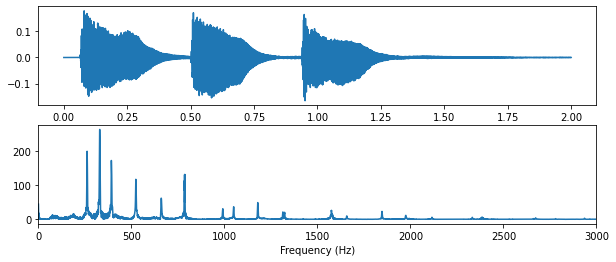

In [20]:
fmp.plot_fft_and_listen('audio/piano_arpeg.wav')

In [21]:
x = fmp.load_wav('audio/piano_arpeg.wav') * 5
fs = 22050.
w_len = 2048
win_pos = np.arange(15) * 2000

@interact(p=fmp.slider(0,len(win_pos)-1))
def sliding_window(p=0):
    # choose window:
    win = np.hanning(w_len)
    
    x_win, win_zp, x_win_zp = window(x, win_pos[p], win)

    ft_mag = magft(x_win)
    
    plt.figure(figsize=(10,10))
    plt.subplot(3,1,1)
    plt.plot(x)
    plt.plot(win_zp, 'r', linewidth=2)
    plt.ylim(-1.5, 1.5)
    plt.subplot(3,1,2)
    plt.title('windowed signal')
    plt.plot(x_win_zp)
    plt.ylim(-1.5, 1.5)
    plt.subplot(3,1,3)
    plt.title(f'$|X(k)|$ for x[n]={win_pos[p]}:{win_pos[p]+w_len}')
    plt.plot(ft_mag)
    plt.xlim(0, 120)
    plt.ylim(0, 300)
    txt = f'$k_{{{"max"}}} = {np.argmax(ft_mag)}$'
    plt.text(100, 250, txt, size=18)
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='p', max=14), Output()), _dom_cl…

In [22]:
# [livecode]
k = 24

f = k * fs / w_len
print(f"freq = {f:.2f} Hz")

p = 64
print(f"pitch = {fmp.freq_to_pitch(f):.2f}")

freq = 258.40 Hz
pitch = 59.79


### The Short Term Fourier Transform

The STFT is the manifestation of the above process. We slide a window across the audio signal and collect the DFT at each step.

The parameters of interest in the STFT are:
- the window length, $N$
- the hop size, $H$
- the window function, $w[n]$ of length $N$ (most often, _Hann_ is chosen)

Or, more formally:

$$\mathcal{X}[k,m] = \sum_{n=0}^{N-1} x[n+mH]w[n]e^{-j 2 \pi k n / N }   $$

with $k \in [0:N/2+1]$ and $m \in [0:M-1]$

The magnitude-squared of the STFT $\lvert \mathcal{X}[k,m] \lvert^2$ is called the _spectrogram_.

<font color='red'>__Whiteboard__</font>: STFT


In [23]:
x = fmp.load_wav('audio/piano_arpeg.wav')
fs = 22050
win_len = 2048
hop_size = win_len // 4

spec = fmp.stft_mag(x, win_len, hop_size) ** 2

print('Spectrogram matrix size:', spec.shape)

Spectrogram matrix size: (1025, 89)


'spec' is a 2D matrix.

- rows are the FFT bins, indexed by $k \in [0, N/2+1]$
- columns are the "hops", representing points in time, indexed by $m \in [0, M-1]$, where $M$ is the total number of hops

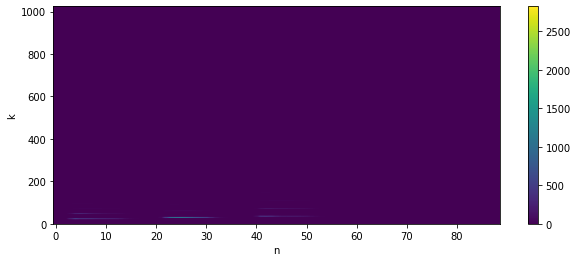

In [24]:
plt.figure()
plt.imshow(spec, origin='lower', aspect='auto')
plt.xlabel('n')
plt.ylabel('k')
plt.colorbar();

Hmmm. this looks mostly dark. It is very common to view a spectrogram by applying a log scale to the amplitudes:

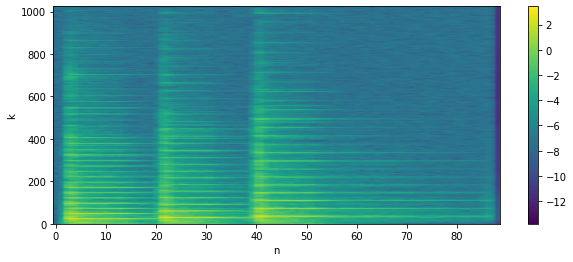

In [25]:
plt.figure()
plt.imshow(np.log10(spec), origin='lower', aspect='auto')
plt.xlabel('n')
plt.ylabel('k')
plt.colorbar();

That's very bright!. Also, we could run into trouble because: $\log_{10}(0) = -\infty$.

Typically, we use a comperssion factor to determine how much we want to boost low values:

$\Gamma_\gamma(v) = \log(1+ \gamma \cdot v)$

- $v$ is the value to compress
- $\gamma$ is the compression factor


In [26]:
@interact(g_idx=(0,5))
def spec_gamma(g_idx=0):
    gamma = (.1,1,10,100,1000,10000)[g_idx]
    plt.figure()
    x = np.linspace(0.0001, 100, 500)
    plt.plot(x, np.log10(1 + x * gamma))
    plt.xlabel('$v$', fontsize=15)
    plt.ylabel('$\Gamma(v)$', fontsize=15)
    plt.title(f'Gamma Compression with $\      gamma$ = {gamma}')
    
    plt.show()

interactive(children=(IntSlider(value=0, description='g_idx', max=5), Output()), _dom_classes=('widget-interac…

In [27]:
@interact(g_idx=(0,4))
def spec_gamma(g_idx=0):
    gamma = (1,10,100,1000,10000)[g_idx]
    plt.figure()
    plt.imshow(np.log10(1 + spec * gamma), origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f'Spectrogram with $\gamma = {gamma}$')
    plt.show()

interactive(children=(IntSlider(value=0, description='g_idx', max=4), Output()), _dom_classes=('widget-interac…

As you can see, enhancing small values also enhances noise in the signal.

### Sidebar: Plotting vs Matrix Axes

Note also that we typically plot with:
- `origin = 'lower'`
- `aspect = 'auto'`

But remember that we think of a matrix's origin is top-left.

### STFT coordinates


Frequency at each bin (each row): $ f(k) = k F_s / N $

Time value of each column: with $ F_f = {F_s \over H} $, $t(m) = {m \over F_f} = {mH \over F_s}$ seconds

Example with $F_s = 22050$, $N=1024$, and $H=256$:
- Frequency at bin 20: $20 \cdot {22050 \over 1024} = 430.66$Hz
- Frequency resolution is: ${22050 \over 1024} = 21.53$Hz per bin


- Time at column 100:$ {100 \cdot 256 \over 22050} = 1.161$ seconds
- Time resolution is: $F_f = {22050 \over 256} = 86.13$Hz or a period of $1/F_f = 11.6$ms

<font color='red'>__Whiteboard__</font>: Spectrogram coordinates

### Time-Frequency Tradeoff

Consdier the following signal. It has two sinusoidal frequencies and two "hits".

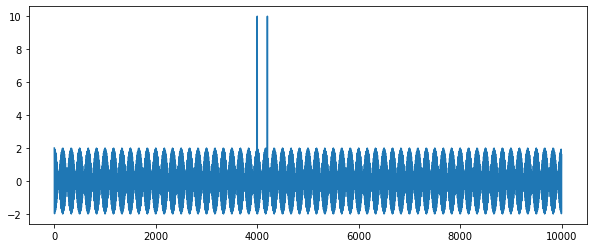

In [28]:
N = 10000
x = make_cosine(1, 1000, 0, 10000) + make_cosine(1, 1060, 0, 10000)
x[4000] = 10
x[4200] = 10

plt.figure()
plt.plot(x);

In [29]:
win_len = (128,256,512,1024)
zp_factor = (8,4,2,1)
@interact(w=(0,3))
def spec_win(w=0):
    wl = win_len[w]
    zp = zp_factor[w]
    spec = fmp.stft_mag(x, wl, 100, zp_factor=zp)[:200,:]
    plt.figure()
    plt.imshow(np.log10(1 + spec * 100), origin='lower', aspect='auto', cmap='gray')
    plt.xlim(0, 100)
    plt.colorbar()
    plt.title('$N=%d$' % wl)
    plt.show()

interactive(children=(IntSlider(value=0, description='w', max=3), Output()), _dom_classes=('widget-interact',)…

## Look and Listen

Let's look at a spectrogram of a song and follow along.

In [30]:
import os
# os.system('open audio/beatles_let_it_be.wav -a "Sonic Visualiser"')